# 1. Agafar el text d'una web

In [7]:
# %pip install spacy
# !python -m spacy download es_core_news_sm
# !python -m spacy download en_core_web_sm
# !python -m spacy download ca_core_news_sm
# %pip install WordCloud
# !pip install --upgrade transformers tokenizers sentencepiece
# !pip install sentencepiece
# !pip install trafilatura




from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
import spacy
import string
import numpy as np
from bs4 import BeautifulSoup   
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer           #eina de stemming              #diccionari de freqüències
from wordcloud import WordCloud                 #eina de visualització
import matplotlib.pyplot as plt
from transformers import pipeline

import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm
nltk.download('punkt_tab')
nltk.download('gutenberg')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Alvaro\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\Alvaro\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Alvaro\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration


def generate_summary_b(article_text):
    
    model_name = "t5-base"
    tokenizer = T5Tokenizer.from_pretrained(model_name, model_max_length=512)
    model = T5ForConditionalGeneration.from_pretrained(model_name)
    # Prefix obligatori per a T5
    input_text = f"summarize: {article_text.strip()}"
    
    # Tokenització i codificació
    inputs = tokenizer(
        input_text, 
        return_tensors="pt", 
        max_length=512, 
        truncation=True
    )

    with torch.no_grad():
        outputs = model.generate(
            inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            num_beams=4,
            max_length=150,
            min_length=40,
            output_scores=True,
            return_dict_in_generate=True
        )

    # Decodificació
    resumen = tokenizer.decode(outputs.sequences[0], skip_special_tokens=True)
    
    logits = torch.stack(outputs.scores, dim=1) 
    probs = torch.softmax(logits, dim=-1)
    
    # Tokens generats (excloent el token inicial)
    gen_tokens = outputs.sequences[:, 1:1 + logits.shape[1]]
    
    # Obtenir probabilitats de tokens generats
    gen_probs = torch.gather(probs, 2, gen_tokens.unsqueeze(-1))
    confianza = torch.mean(gen_probs).item()

    print(f"Confianza del resumen: {confianza:.4f}")
    print(f"Resumen generado: {resumen}")
    return resumen, confianza

In [9]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

# Ex 3
def train_model(tokens):
    # Càrrega de dades
    data = fetch_20newsgroups(subset='train', categories=[
        'sci.med', 'sci.space', 'sci.electronics', 'sci.crypt',
        'rec.autos', 'rec.sport.hockey', 'comp.graphics',
        'talk.politics.misc', 'soc.religion.christian', 'misc.forsale'
    ])

    # 2. Entrenament
    modelo_entrenado = make_pipeline(CountVectorizer(), MultinomialNB())
    modelo_entrenado.fit(data.data, data.target)
    nombres_categorias = data.target_names

    # Processament article tokenitzat
    tokenized_string = " ".join(tokens)

    # Predicció
    prediccion_indice = modelo_entrenado.predict([tokenized_string])

    # Resultat
    categoria_final = nombres_categorias[prediccion_indice[0]]
    
    print(f"Classificat com: {categoria_final}")
    return categoria_final


In [10]:
# Impressio paraules més freqüents
def show_wordcloud(txt):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(txt)

    # Mostrar el núvol de paraules
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  
    plt.show()

In [11]:
# Ex 2

def title_article_preprocessing_a(clean_text):
    # Tokenitzar text
    tokens = word_tokenize(clean_text, language='spanish')
    
    # Normalitzar text
    tokens = [t.lower() for t in tokens if t.isalpha()]  # Nomès paraules
    
    # 3. Eliminar palabras vacías (stopwords)
    stop_words = set(stopwords.words('spanish'))
    tokens = [t for t in tokens if t not in stop_words]
    
    print(tokens[:50])  # Mostrar primers 50 tokens


def title_article_preprocessing_b(clean_text):
    # Carrega del model
    
    nlp = spacy.load("en_core_web_sm")
    
    # Processament
    doc = nlp(clean_text)
    
    # 1. Neteja bàsica amb spaCy (Eliminar stop words i puntuació)
    tokens_limpios = [
    token.text.strip() 
    for token in doc 
    if not token.is_stop and not token.is_punct and not token.is_space
    ]

    # Per si de cas queda algun string buit després del strip()
    tokens_limpios = [t for t in tokens_limpios if t]

    print(f"Primers 20 tokens nets (Opció B): {tokens_limpios[:20]}")
    
    show_wordcloud(' '.join(tokens_limpios))
    train_model(tokens_limpios)




Home
BMC Biology
Article
Comparative analysis of morabine grasshopper genomes reveals highly abundant transposable elements and rapidly proliferating satellite DNA repeats
Research article
Open access
Published:
21 December 2020
Volume 18
, article number
199
, (
2020
)
Cite this article
You have full access to this
open access
article
Download PDF
Save article
View saved research
BMC Biology
Aims and scope
Submit manuscript
Comparative analysis of morabine grasshopper genomes reveals highly abundant transposable elements and rapidly proliferating satellite DNA repeats
Download PDF
Octavio M. Palacios-Gimenez
ORCID:
orcid.org/0000-0002-1472-9949
1
,
2
,
Julia Koelman
1
,
Marc Palmada-Flores
1
,
Tessa M. Bradford
3
,
4
,
Karl K. Jones
3
,
Steven J. B. Cooper
3
,
4
,
Takeshi Kawakami
1
,
5
na1
&
…
Alexander Suh
1
,
2
,
6
na1
Show authors
6563
Accesses
53
Citations
12
Altmetric
Explore all metrics
Abstract
Background
Repetitive DNA sequences, including transposable elements (TEs) and tand

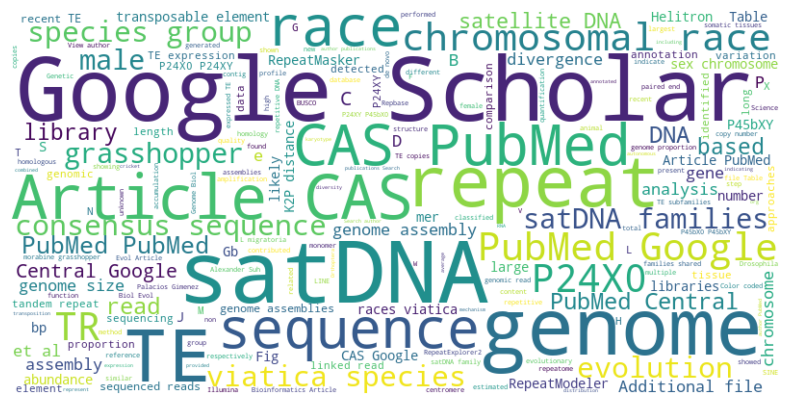

Classificat com: sci.med


In [12]:
import requests
from bs4 import BeautifulSoup

url = "https://link.springer.com/article/10.1186/s12915-020-00925-x"

opcio = input("Selecciona opció A o B")


def scrape_text(url, opcio):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")
    
    # Intentar <article>
    article = soup.find("article")
    if article:
        text = article.get_text(separator="\n")
    else:
        # Intentar <main>
        main = soup.find("main")
        if main:
            text = main.get_text(separator="\n")
        else:

            paragraphs = soup.find_all("p")
            blocks = []
            current_block = []
            for p in paragraphs:
                current_block.append(p.get_text())
                # Separar blocs grans
                if len(current_block) > 3:  
                    blocks.append("\n".join(current_block))
                    current_block = []
            if current_block:
                blocks.append("\n".join(current_block))
            # Escollir el bloc més llarg (probable article)
            text = max(blocks, key=len) if blocks else ""
    
    # Netejar línies buides
    lines = [line.strip() for line in text.splitlines() if line.strip()]
    clean_text = "\n".join(lines)
    

    print(clean_text[:1000])  # Mostrar només 1000 caràcters per verificar el contingut
    if opcio == "A":
        title_article_preprocessing_a(clean_text)
    elif opcio == "B":
        title_article_preprocessing_b(clean_text)
    elif opcio == "C":
        generate_summary_b(clean_text)
    else:
        print("Opció no vàlida")
        
import requests
import trafilatura

def scrape_text_advanced(url):
    try:
        # Descarregar la pàgina web amb un User-Agent vàlid
        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
        }
        
        response = requests.get(url, headers=headers, timeout=15)
        
        # Forcem que la resposta sigui interpretada com a UTF-8
        response.encoding = 'utf-8' 
        
        if response.status_code == 200:
            # 2. Li passem el contingut ja descarregat a trafilatura per només obtenir el cos del text, l'article.
            clean_text = trafilatura.extract(response.text, include_comments=False)
            
            if clean_text:
                print(clean_text[:1000])  # Mostrar només els primers 1000 caràcters
                generate_summary_b(clean_text)
        
        return None

    except Exception as e:
        print(f"Error en la descarga: {e}")
        return None


scrape_text(url, opcio)
# scrape_text_advanced(url)